In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Capstone


Mounted at /content/gdrive
/content/gdrive/MyDrive/Capstone


# Processing Data

In [2]:
import pandas as pd
import string
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
tag_data=pd.read_csv('tag_data.csv')

In [7]:
dt=pd.read_csv('tag_data.csv')

In [ ]:
list(tag_data[tag_data['id']==1344345124159934465]['text'])

['In line to get my first COVID-19 vaccine. Kind of excited to know this long nightmare is almost over. I am a healthcare worker which is why I am getting it now. #CovidVaccine']

In [4]:
puncts = list(string.punctuation)
def clean_data(text):
  # delete punctuation
  for punc in puncts:
    if punc in text:
      text = text.replace(punc, f'')
  #make the text lower case
  text=text.lower()
  # delete the url
  text=re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text)
  # delete the email
  text=re.sub(r'^([\w]+\.*)([\w]+)\@[\w]+\.\w{3}(\.\w{2}|)', '', text)
  # delete @someone
  text=re.sub(r'@\S+', '', text)
  # delete #tags
  text=re.sub(r'#\S+', '', text)
  # delete \n
  text=re.sub(r'^\s*$(?:\n|\r\n)', '', text)
  return text

In [5]:
tag_data['text']=tag_data['text'].apply(clean_data)

In [ ]:
nlp = spacy.load('en_core_web_sm')
stopwords=list(STOP_WORDS)
for word in stopwords:
    nlp.vocab[word].is_stop = True
tag_data['text'] = tag_data['text'].apply(lambda text: 
                                          " ".join(token.lemma_ for token in nlp(text) 
                                                   if not token.is_stop))

In [ ]:
wnl = WordNetLemmatizer() 
for i in range(len(tag_data)):
  tag_data['text'][i]=wnl.lemmatize(tag_data['text'][i])

In [ ]:
tag_data.columns

Index(['Unnamed: 0', 'coordinates', 'created_at', 'hashtags', 'media', 'urls',
       'favorite_count', 'id', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_user_id', 'lang', 'place',
       'possibly_sensitive', 'quote_id', 'retweet_count', 'retweet_id',
       'retweet_screen_name', 'source', 'text', 'tweet_url', 'user_created_at',
       'user_id', 'user_default_profile_image', 'user_description',
       'user_favourites_count', 'user_followers_count', 'user_friends_count',
       'user_listed_count', 'user_location', 'user_name', 'user_screen_name',
       'user_statuses_count', 'user_time_zone', 'user_urls', 'user_verified',
       'tag'],
      dtype='object')

In [ ]:
tag_data=tag_data.drop_duplicates(subset='id', keep='first', inplace=False)

In [ ]:
len(set(tag_data['id']))

46785

In [ ]:
len((tag_data['id']))

46785

In [ ]:
tag_data[tag_data['tag']==False][['text','tag']]

,text,tag
3,well it happened my daughter used my grandchil...,False
5,hmmm for idaho 56225 covid vaccines available...,False
10,56225 covid vaccines available and only 15780 ...,False
16,listen to all these mds who affirm the need fo...,False
18,covid19 delaying second doses of vaccine is th...,False
...,...,...
47738,i don’t think people have fully digested this ...,False
47739,the main argument im getting against my prior ...,False
47740,i feel like this is the video that perfectly d...,False
47741,more and more\n\nhttpstcoz5dpu7rasa,False


# Processing

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import WordPunctTokenizer
from sklearn.svm import LinearSVC, SVC

In [8]:
dt.head(5)

,id,text,tag
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [10]:
dt.loc[dt['tag']=="real",'tag'] = 1
dt.loc[dt['tag']=="fake",'tag']  = 0

In [14]:
pip_lr = Pipeline([
        ('bow', TfidfVectorizer(ngram_range=(1,2), max_features=10000)),  
        ('tfidf', TfidfTransformer()),  
        ('c', LogisticRegression())
        ])

In [15]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(dt['text'],dt['tag'],test_size=0.3)

In [16]:
fit = pip_lr.fit(Train_X,Train_Y.astype(int))

In [19]:
? plot_confusion_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


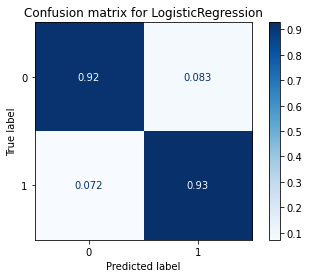

In [21]:
# Generate confusion matrix
matrix = plot_confusion_matrix(pip_lr, Test_X, Test_Y.astype(int),
                                 cmap=plt.cm.Blues,normalize='true')
plt.title('Confusion matrix for LogisticRegression')
plt.show(matrix)
plt.show()

In [ ]:
dataset_pred=pip_lr.predict(Test_X)

In [ ]:
Test_Y

In [ ]:
accuracy_score(y_true=list(Test_Y), y_pred=list(dataset_pred))

0.9340602284527518

In [ ]:
from sklearn.metrics import average_precision_score
average_precision_score(y_true=list(Test_Y), y_score=list(dataset_pred))

0.9069342347008194

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_true=list(Test_Y), y_pred=list(dataset_pred))

0.9391480730223124

In [ ]:
list(dataset_pred)

In [ ]:
pip_lr.score(Test_X, Test_Y.astype(int))

0.9221183800623053

In [22]:
# create a function for the tweet tokenizer from NLTK
# pipe = Pipeline([('count', CountVectorizer()),
#                  ('tfid', TfidfTransformer()),

#                  ])
pip = Pipeline([
        ('bow', TfidfVectorizer(ngram_range=(1,2), max_features=10000)),  
        ('tfidf', TfidfTransformer()),  
        ('c', svm.SVC())
        ])

In [25]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(dt['text'],dt['tag'],test_size=0.3)

In [26]:
fit = pip.fit(Train_X,Train_Y.astype(int))

In [ ]:
pip.score(Test_X, Test_Y.astype(int))

0.9739579696990854

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


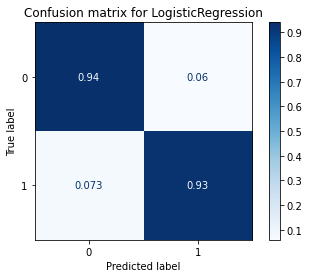

In [30]:
# Generate confusion matrix
matrix = plot_confusion_matrix(pip, Test_X, Test_Y.astype(int),
                                 cmap=plt.cm.Blues,normalize='true')
plt.title('Confusion matrix for SVM')
plt.show(matrix)
plt.show()

In [ ]:
y_pred=pip.predict(Test_X)

In [ ]:
accuracy_score(y_true=list(Test_Y), y_pred=list(y_pred))

0.9434060228452752

In [ ]:
from sklearn.metrics import average_precision_score
average_precision_score(y_true=list(Test_Y), y_score=list(y_pred))

0.922261074900814

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_true=list(Test_Y), y_pred=list(y_pred))

0.9411764705882353